#  Glass Classification Report

## Introduction

   Glass is a ubiquitous material that can be found at most crime scenes. The classification of glass fragments is an essential aspect of forensic investigation, particularly in cases that involve broken windows, bottles and/or any other glass objects that can be found present. It can provide crucial evidence that may help investigators identify suspects or even vindicate the innocent. Glass fragments can be found on clothing and vehicles in addition to being recovered from wounds and weapons. These fragments can provide valuable clues about the source, direction and nature of the impact that led to them to break, which can be useful to investigators when reconstructing the sequence of events leading up to the crime. However, not all glass is created equal, and the classification of glass is essential to determining its origin and potential significance as well as for ruling out false matches.

   An article written by Grzegorz Zadora titled Glass analysis for forensic purposes- a comparison of classification methods states that many forensic experts analyze glass fragments under 0.5mm, therefore they must be able to accurately collect the physico-chemical features of the glass, such as Refractive Index (RI) in addition to elemental analysis. By using Scanning Electron Microscopy that has been coupled with an Energy Dispersive X-ray spectrometer (SEM-EDX), the investigators are provided with the information of major and minor elements such as Al, Mg, K, Ca and Fe. Furthermore, it is believed that obtaining the information about such elements are extremely important when comparing and individualizing the glass fragments (Zadora, G. 2007).
   
   The dataset used was sourced from the UCI Machine Learning Repository. The chosen dataset, Glass Identification (German, B. 1987) comes from the USA Forensic Science Service and classifies 6 types of glass based on their oxide content, along with the refractive index of each glass observation. Float glass is a type of glass that is produced by floating molten glass on a bed of molten metal, usually tin. This process produces high quality and uniform glass with a smooth, thick, and flat surface (Levy, D. 2016). Float glass is widely used for windows and doors due to their many benefits of resistance to heat and breakage. In this dataset, there is no data for “vehicle_windows_non_float_processed” glass. 
   
<b>More details on the glass identification dataset:</b>

<b>Glass Oxides (measured in weight percent)</b>
<ul>
<li>Na: Sodium</li>
<li>Mg: Magnesium</li>
<li>Al: Aluminum</li>
<li>Si: Silicon</li>
<li>K: Potassium</li>
<li>Ca: Calcium</li>
<li>Ba: Barium</li>
<li>Fe: Iron</li>
</ul>
<b>Glass Types</b>
<ul>
<li>building_windows_float_processed</li>
<li>building_windows_non_float_processed</li>
<li>vehicle_windows_float_processed</li>
<li>vehicle_windows_non_float_processed (**none in this dataset**)</li>
<li>containers</li>
<li>tableware</li>
<li>headlamps</li>
</ul>

 
 The <b>guiding question</b> of this analysis is as follows: To what degree of accuracy can oxide percentage in glass predict its type?

   Our group identified the most salient predictors for determining glass type, specifically being Sodium, Magnesium, Aluminum, Silicon, Potassium, and Calcium. The exclusion of Barium and Iron oxides was a deliberate decision made due to the limited availability of data on these variables. Furthermore, the decision to exclude Refractive Index (RI) was driven by the primary focus of the analysis; to predict glass type based on oxide content. Our analysis involved the development of a model using the k-nearest neighbors (k-NN) algorithm, which yielded an accuracy rate of 73% with the nearest neighbors value set to 1. The k-NN model has surpassed the baseline model by effectively recognizing data patterns and providing more informed predictions concerning glass types. In essence, our findings indicate that the k-NN model is a valuable tool for discerning data patterns and facilitating informed predictions regarding glass types.
   

## Methods & Results

In [32]:
install.packages("themis")
library(tidyverse)
library(repr)
library(tidymodels)
library(themis)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



#### Load Data From the Original Source

Here we load the data from the original source with new column names and visualized a few rows of raw data in `glass_data_raw`.

In [2]:
set.seed(999)

dataset_url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data"
col_names <- c("id", "RI", "Na", "Mg", "Al", "Si", "K", "Ca", "Ba", "Fe", "glass_type")
glass_data_raw <- read.table(dataset_url, sep =",", header = FALSE, col.names = col_names)

sample_n(glass_data_raw, 5)

id,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,glass_type
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
155,1.51694,12.86,3.58,1.31,72.61,0.61,8.79,0,0.00,3
68,1.52152,13.05,3.65,0.87,72.32,0.19,9.85,0,0.17,1
61,1.51905,13.60,3.62,1.11,72.64,0.14,8.76,0,0.00,1
71,1.51574,14.86,3.67,1.74,71.87,0.16,7.36,0,0.12,2
105,1.52410,13.83,2.90,1.17,71.15,0.08,10.79,0,0.00,2


#### Wrangle and Clean the Data

Here we change the glass_type column to a factor type, remove the refractive index column (RI) and ID (id), and replace the glass_type numbers with their corresponding labels. There were no empty observations in the data and all oxides were noted in the same units. We also visualize a few rows of `glass_data_processed`.

In [33]:
set.seed(999)

glass_data_raw <- glass_data_raw |> mutate(glass_type = as_factor(glass_type))
glass_type_names <- c("building_windows_float_processed", "building_windows_non_float_processed", "vehicle_windows_float_processed", "containers", "tableware", "headlamps")
glass_data_processed <- glass_data_raw |> select(-RI, -id)
levels(glass_data_processed$glass_type) <- glass_type_names

sample_n(glass_data_processed, 5)

Na,Mg,Al,Si,K,Ca,Ba,Fe,glass_type
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
12.86,3.58,1.31,72.61,0.61,8.79,0,0.00,vehicle_windows_float_processed
13.05,3.65,0.87,72.32,0.19,9.85,0,0.17,building_windows_float_processed
13.60,3.62,1.11,72.64,0.14,8.76,0,0.00,building_windows_float_processed
14.86,3.67,1.74,71.87,0.16,7.36,0,0.12,building_windows_non_float_processed
13.83,2.90,1.17,71.15,0.08,10.79,0,0.00,building_windows_non_float_processed


#### Data Set Summary and Exploratory Data Analysis

**Glass Type Counts**<br>

Visualizing the glass type counts of the data set we can see that the observations of each glass type are not balanced. For example there is a proporitionally high number of building_windows_float_processed observations compared to low tableware observations. This may lead to a bias towards our model predicting the higher count classes so to try and mitigate this we will use step_upsample from the themis package to balance the observations during the creation of the model.

In [34]:
glass_type_counts <- glass_data_processed |>
    group_by(glass_type) |>
    summarize(count = n()) 

glass_type_counts

glass_type,count
<fct>,<int>
building_windows_float_processed,70
building_windows_non_float_processed,76
vehicle_windows_float_processed,17
containers,13
tableware,9
headlamps,29


**Average Weight Percent of Oxide per Glass Type**<br>

Here we visualize the average weight percentage of oxides for every glass type. This allows us to compare the average weight percent of each oxide between glass types.

Based on the visualization we can see that many oxides fall between a narrow range of values for all glass types. Two oxide types in particular - Barium and Iron - are almost 0 for all the glass types and may not be as good as predictors.

`summarise()` has grouped output by 'glass_type'. You can override using the
`.groups` argument.


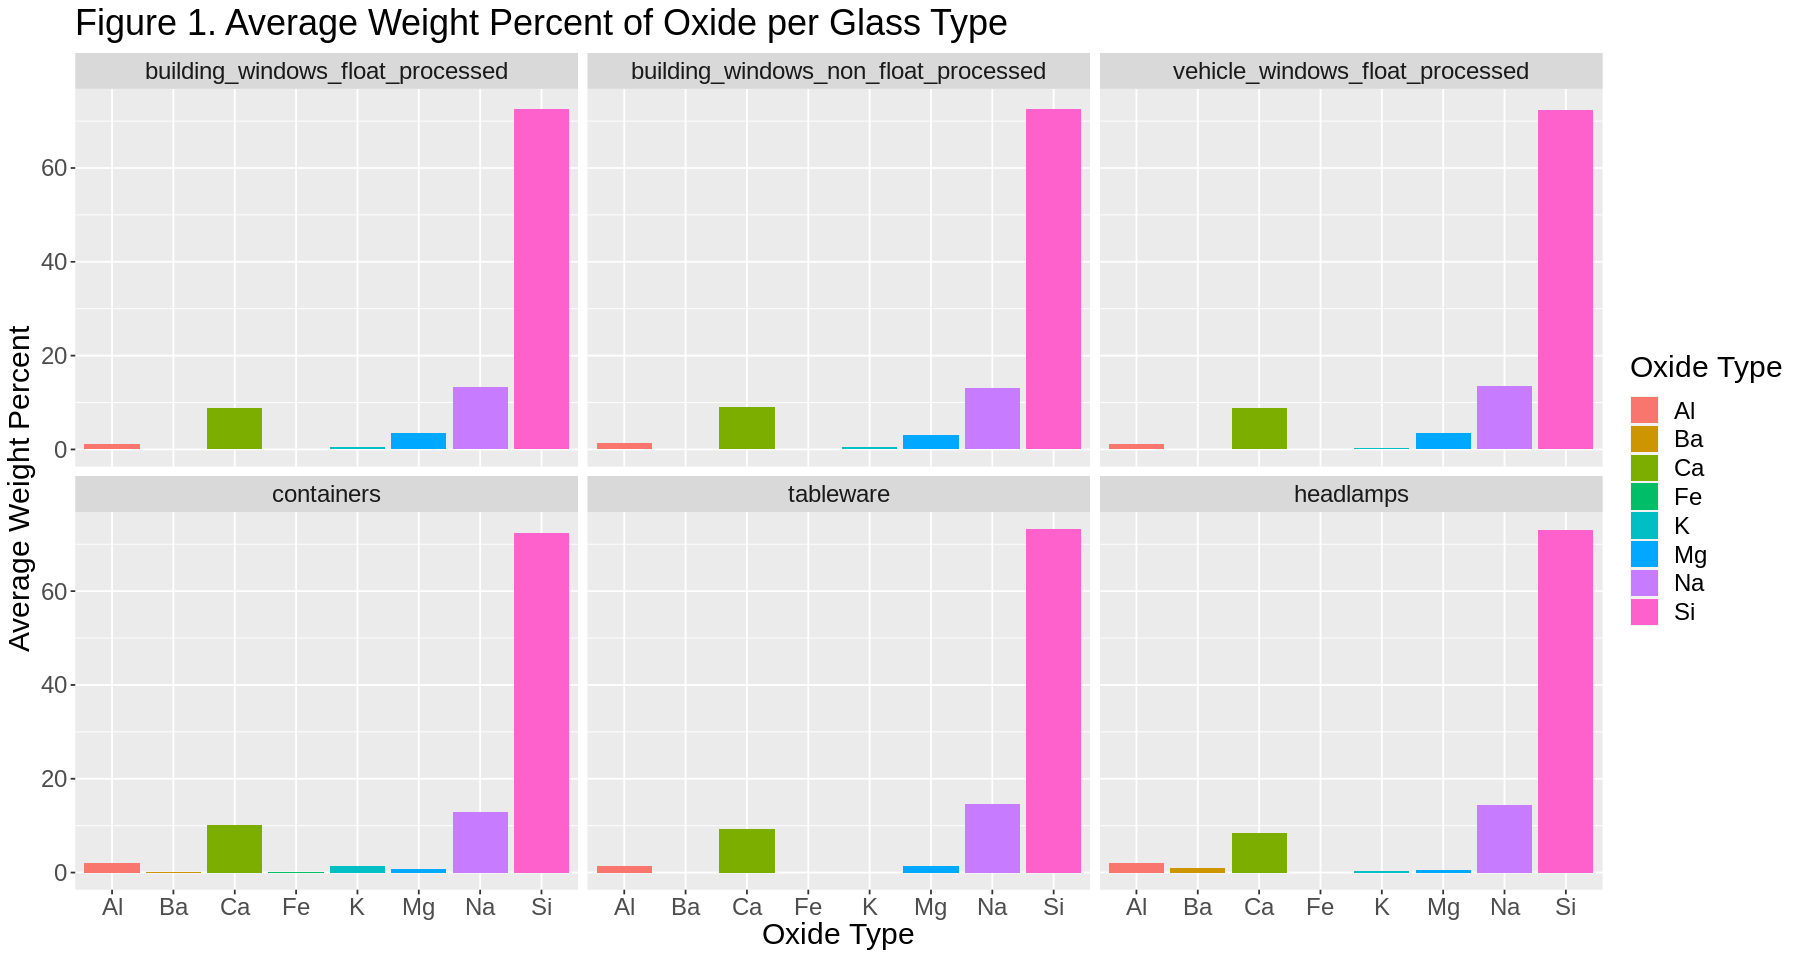

In [35]:
options(repr.plot.width=15, repr.plot.height=8)

glass_visual_data <- glass_data_processed |>
    pivot_longer(cols = Na:Fe, names_to = "oxide_type", values_to = "weight_percent") |>
    group_by(glass_type, oxide_type) |>
    summarise(mean_weight_percent = mean(weight_percent)) |>
    ungroup()

glass_visual_plot <- glass_visual_data |>
    ggplot(aes(x = oxide_type, y = mean_weight_percent, fill = oxide_type)) +
    geom_bar(stat = "identity", position = "dodge") +
    labs(x = "Oxide Type", y = "Average Weight Percent", fill = "Oxide Type") +
    facet_wrap(~glass_type, nrow = 2) +
    theme(text = element_text(size = 18)) +
    ggtitle("Figure 1. Average Weight Percent of Oxide per Glass Type")

glass_visual_plot

To decide on what predictors we should use, we can also analyze the range of values of all oxides in the original dataset.  We can assume that oxides with larger ranges of values can be better predictors of glass type. The range can be calculated by subtracting the maximum and minimum values that appear in the dataset. As can be noted in Fig 1. many glass times have almost no Ba and the mean value and range is both relatively low. A similar phenomenon can be seen for Fe. Thus, these two variables will be removed as predictors. 

In [36]:
sample <- glass_data_raw |>
            select(-c(RI, id, glass_type))


glass_min <- apply(sample, 2, min)
glass_max <- apply(sample, 2, max)
glass_range <- round(glass_max - glass_min, 1)
glass_mean <- round(apply(sample, 2, mean), 1)

cat("Range of values")
glass_range
cat("Mean value")
glass_mean

Range of values

Na   Mg   Al   Si    K   Ca   Ba   Fe 
 6.6  4.5  3.2  5.6  6.2 10.8  3.1  0.5

Mean value

Na   Mg   Al   Si    K   Ca   Ba   Fe 
13.4  2.7  1.4 72.7  0.5  9.0  0.2  0.1

#### Performing the Data Analysis

**Updating the Data & Splitting the Data**<br>

Here we remove Barium and Iron from the data set because our exploratory analysis shows they have the lowest range in values. The data set is then split into a training and testing set called `glass_train` and `glass_test`, respectively. The model will be trained with 80% of the data.

In [37]:
set.seed(9999)

# Reanme final processed data set to improve readability
glass_data <- glass_data_processed

# Remove Barium, and Iron
glass_data <- glass_data |> select(-Ba, -Fe)

# Split dataset into training and testing data
glass_split <- initial_split(glass_data, prop = 0.8, strata=glass_type)
glass_train <- training(glass_split)
glass_test <- testing(glass_split)

**Choosing the Optimal Number of Neighbors $k$** <br>

Here we use 5-fold cross-validation on the training data set to select which 𝑘 (neighbors) is the most optimal for our data set for k-nn classification.<br>

The steps performed:
- Create model specification with tuning on the number of neighbours
- Create a recipe that uses all predictors in `glass_data`. Here we also add steps for scaling, centering, and balancing the data.
- Perform 5-fold cross validation
    - Using a workflow that tries neighbours 1 through 20
- Collect the metrics from the results of the workflow analysis
- Extract the accuracies from the metrics into the `accuracies` object


In [12]:
set.seed(999)

# Create model specification with tuning on the number of neighbours
glass_spec <- nearest_neighbor(weight_func="rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# Create a recipe that uses all predictors
glass_recipe <- recipe(glass_type ~ ., data = glass_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    step_upsample(glass_type)

# Perform 5-fold cross validation
vfold <- vfold_cv(glass_train, v=5, strata=glass_type)

vals <- tibble(neighbors = seq(from=1, to = 20))

# Create a workflow analysis trying k in vals
knn_results <- workflow() |>
    add_recipe(glass_recipe) |>
    add_model(glass_spec) |>
    tune_grid(resamples = vfold, grid = vals)

# Collect the metrics
knn_results <- knn_results |> collect_metrics()

accuracies <- knn_results |>
    filter(.metric =="accuracy")

! Fold1: internal:
  No observations were detected in `truth` for level(s): 'tableware'
  Computation will proceed by ignoring those levels.

! Fold4: internal:
  No observations were detected in `truth` for level(s): 'tableware'
  Computation will proceed by ignoring those levels.



We then plot the $k$ (neighbors) vs the accuracy. <br>

Based on this graph we can see that the accuracy estimate decreases as the number of neighbors increases. The best estimated accuracy is around ~70% which is given with 1 or 2 neighbors.

neighbors,mean
<int>,<dbl>
1,0.7046324
2,0.7046324
3,0.6589496
4,0.6646639
5,0.6420063
6,0.6300420


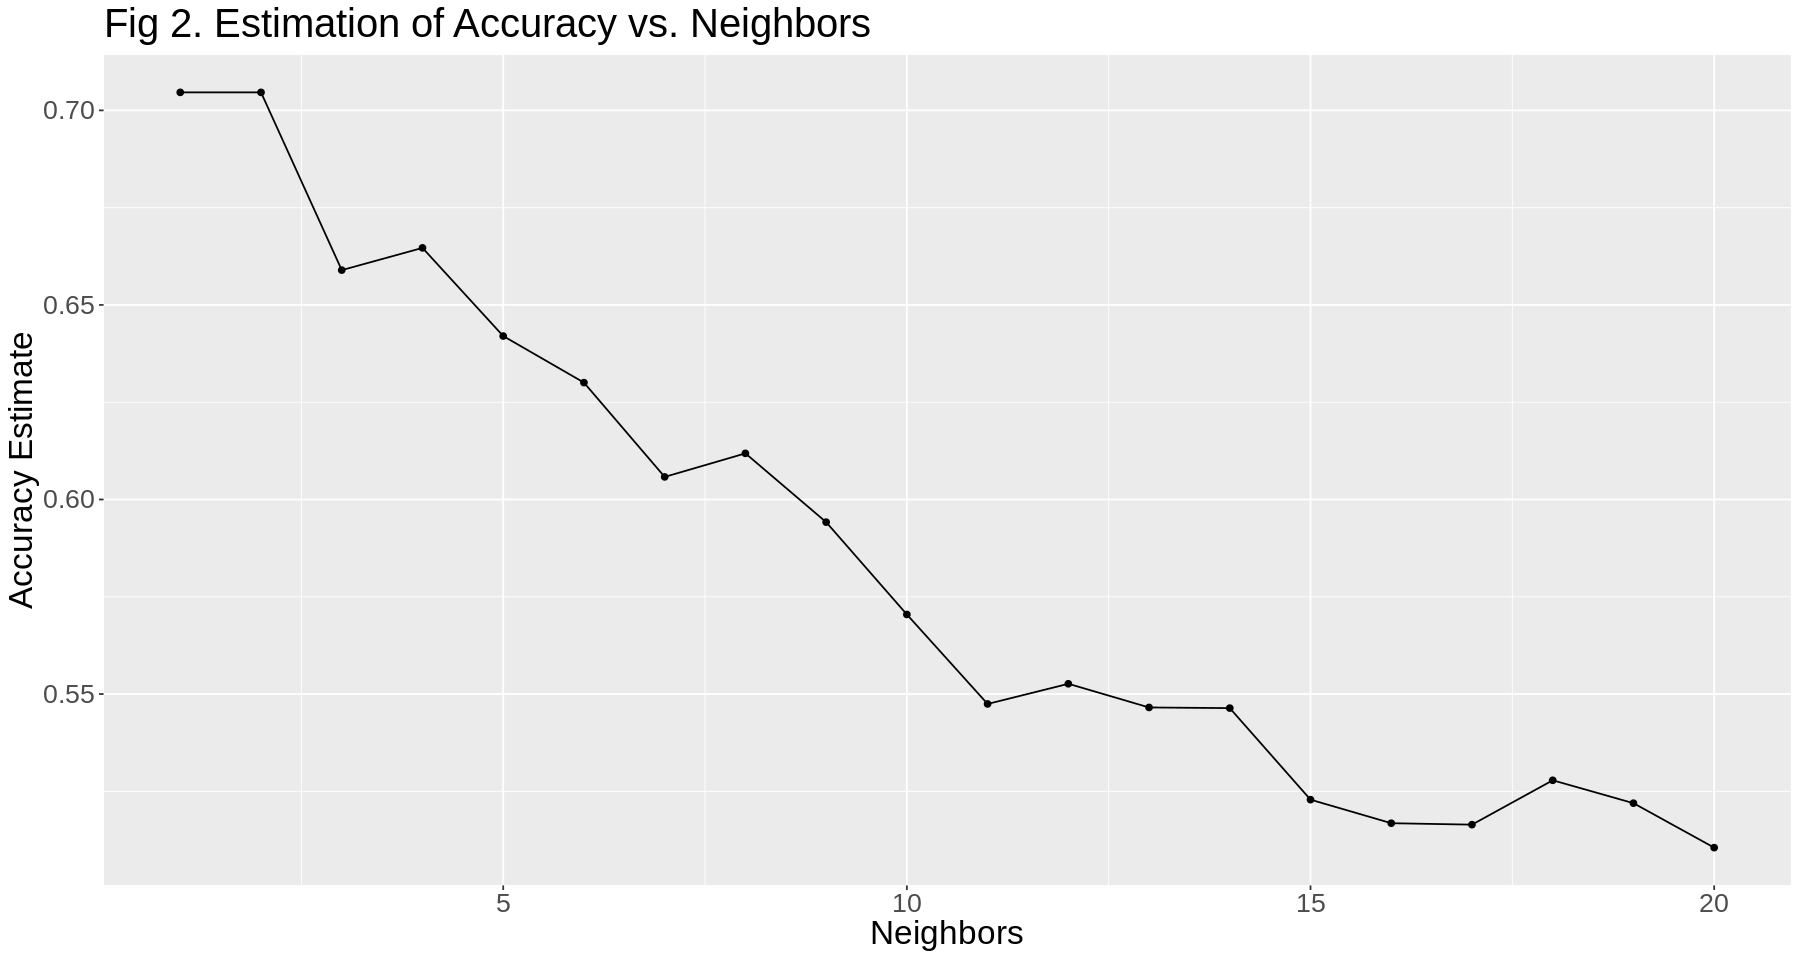

In [17]:
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 20)) +
  ggtitle("Figure 2. Estimation of Accuracy vs. Neighbors")
accuracy_vs_k

select(head(accuracies), neighbors, mean)

**Build the Model**<br>

Here we first extract the number of neighbours that gives us the highest accuracy based on the `accuracies` object created. The best number of neighbors is 1. We build our model specification with the best number of neigbhors then, pass the model specification and the training data set to the fit() function.

In [18]:
set.seed(999)

# Get the number of neighbors that gave the highest accuracy
best_neighbors <- accuracies$neighbors[which.max(accuracies$mean)]

# Build model specification with the best value for k
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_neighbors) |> 
            set_engine("kknn") |> 
            set_mode("classification") 

knn_fit <- workflow() |> 
            add_recipe(glass_recipe) |> 
            add_model(knn_spec) |> 
            fit(data = glass_train) 

**Predicting on the Test Data**<br>

We use our final model to predict on the test dataset and assign this to an object called `glass_test_predictions`. 

In [19]:
set.seed(999)

glass_test_predictions <- predict(knn_fit, glass_test) |> 
                            bind_cols(glass_test)

head(glass_test_predictions)

.pred_class,Na,Mg,Al,Si,K,Ca,glass_type
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
building_windows_float_processed,13.27,3.62,1.24,73.08,0.55,8.07,building_windows_float_processed
building_windows_non_float_processed,14.04,3.58,1.37,72.08,0.56,8.30,building_windows_float_processed
building_windows_float_processed,13.00,3.60,1.36,72.99,0.57,8.40,building_windows_float_processed
building_windows_non_float_processed,12.88,3.43,1.40,73.28,0.69,8.05,building_windows_float_processed
building_windows_float_processed,12.68,3.67,1.16,73.11,0.61,8.70,building_windows_float_processed
vehicle_windows_float_processed,12.98,3.54,1.21,73.00,0.65,8.53,building_windows_float_processed


<br>We report the accuracy of this prediction, and store this in an object named `glass_test_metrics`.

Here we can see that the accuracy of our model on the test dataset is 72.7%

In [25]:
set.seed(999)

glass_test_metrics <- glass_test_predictions |>
    metrics(truth = glass_type, estimate = .pred_class) |>
    select(-.estimator) |>
    filter(.metric == 'accuracy')

glass_test_metrics

.metric,.estimate
<chr>,<dbl>
accuracy,0.7272727


<br>We then report the confusion matrix and and store this in an object named `glass_test_conf_mat`. As can be seen from the confusion matrix, certain glass types had higher rates of truths than others. Since data was upscaled, we don't see any obvious patterns in error or the tendency of overassign a certain glass type that is incorrect.

In [38]:
set.seed(999)

glass_test_conf_mat <- glass_test_predictions |> 
    conf_mat(truth = glass_type, estimate = .pred_class)
glass_test_conf_mat

                                      Truth
Prediction                             building_windows_float_processed
  building_windows_float_processed                                   10
  building_windows_non_float_processed                                2
  vehicle_windows_float_processed                                     2
  containers                                                          0
  tableware                                                           0
  headlamps                                                           0
                                      Truth
Prediction                             building_windows_non_float_processed
  building_windows_float_processed                                        1
  building_windows_non_float_processed                                   12
  vehicle_windows_float_processed                                         1
  containers                                                              1
  tableware                 

<br> Additonally, we can get the percentages of correct predictions for each `glass_type`. Note again that due to upscaling, there isn't an obvious correlations between number of observations in the dataset for a glass type and the percentage of correct predictions.

In [39]:
glass_test_pred_correct_pct <- glass_test_predictions |> 
    group_by(glass_type) |>
    summarize(correct_pred_pct = sum(.pred_class == glass_type)/n()) |>
    mutate(correct_pred_pct = round(correct_pred_pct * 100,digits = 2))

glass_test_pred_correct_pct

glass_type,correct_pred_pct
<fct>,<dbl>
building_windows_float_processed,71.43
building_windows_non_float_processed,75.00
vehicle_windows_float_processed,100.00
containers,100.00
tableware,25.00
headlamps,85.71


**Determine an Accuracy Baseline**

Here we determine an accuracy baseline based on a model that always chooses the most common class.

In [31]:
# Get the accuracy of the KNN model with the best number of neighbors
knn_accuracy <-pull(select(glass_test_metrics, .estimate))

# Implementing the Most Common Class model
# Create a table of class counts in the training data
class_counts <- table(glass_train$glass_type)
# Get the class with the highest count
most_common_class <- names(which.max(class_counts))
# Create a vector of predictions for the test data using the most common class
most_common_predictions <- rep(most_common_class, nrow(glass_test))
# Calculate the accuracy of the baseline model
most_common_accuracy <- mean(most_common_predictions == glass_test$glass_type)

# Create tibble with accuracies of both models
accuracy_tbl <- tibble(Model = c("KNN", "Most Common"),
                       Accuracy = c(knn_accuracy, most_common_accuracy))
accuracy_tbl

Model,Accuracy
<chr>,<dbl>
KNN,0.7272727
Most Common,0.3636364


The difference in accuracy between the k-NN model and the most common class baseline model provides valuable insights into the performance and effectiveness of our model. The k-NN model has an accuracy of approximately 73%, while the baseline model has an accuracy of approximately 36%. This indicates that the k-NN model is performing significantly better than the baseline model, successfully learning patterns from the data and making more informed predictions about the glass types. <br/>
The comparison between the two models evaluates whether the k-NN model is adding value and improving upon the approach of always predicting the most common class. With a difference of about 34 percentage points, the k-NN model demonstrates its ability to capture the relationships within the data, resulting in more accurate predictions. However, an accuracy of 73% for the k-NN model might still not be high enough.

## Discussion 

During examining the Glass Classification data set, our group identified the most pertinent predictors for determining glass type to be Sodium, Magnesium, Aluminum, Silicon, Potassium, and Calcium. The exclusion of Barium and Iron oxides was a result of the lack of available data, and relatively small range of values for these variables. The decision to remove Refractive Index (RI) was driven by the primary focus of the analysis, namely: can the weight percentage of oxides alone be used to classify glass type? The aim of this analysis was to expedite crime solving by providing forensic investigators with valuable information on oxide content, enabling them to identify the type of glass recovered as evidence. Glass is frequently encountered as physical evidence in criminal investigations and can furnish key insights into the circumstances of the crime, such as the trajectory of projectiles that may have shattered the glass. These insights can, in turn, help investigators to narrow down potential suspects and build a stronger case. 

During the process of creating our model, it became apparent that the data analysis on testing data yielded an accuracy of 73%, leaving its efficacy open to interpretation. It is noteworthy that the accuracy of the model reflects its ability to make accurate predictions without accessing the glass types of the testing data (Timbers et al. 2022). Thus, it is crucial to analyze the confusion matrix, which highlights the correct prediction percentages for each glass type. Notably, the range varied from 25% to 100%, with tableware exhibiting a low of 25%, whereas vehicle_windows_float_processed and containers demonstrated the highest of 100%. To acquire this vital conclusion, a 5-fold cross-validation of the training data was conducted, aiming to identify the optimal number of neighbors (k) necessary for precise data classification. 

Figure 2, Estimation of Accuracy vs. Neighbors, indicated that accuracy estimates decrease exponentially as the number of neighbors increases, thereby implying that a low k value would enhance the analysis's precision. The highest accuracy determined here was 70%, based on multiple splits of the training data. The k-NN model run on the testing data exhibits a noteworthy accuracy rate of roughly 73%, in stark contrast to the baseline model's accuracy rate of approximately 36%. Such a marked disparity between the two models implies that the k-NN model is surpassing the baseline model by successfully discerning data patterns and providing more informed predictions regarding glass types. This comparison of the two models serves to evaluate whether the k-NN model is augmenting the approach of relying on the most common class to make predictions. With a substantial margin of around 37 percentage points, the k-NN model showcases its ability to capture the intricate relationships within the data, thereby generating more precise predictions.

At the outset, our initial hypothesis posited that the production of float-processed glass would result in higher silicon concentrations due to the prevalent presence of silica during the melting process(Levy, D. 2016). Moreover, we inferred that each variant of glass would display a distinct ratio of weight percentage oxides based on our early analysis. Drawing upon our visualization, we constructed a bar chart to contrast oxide type on the x-axis with average weight percentage on the y-axis, and further examined each glass type against one another. Our analysis revealed that the quantities of silicon are highly comparable indicating that our original hypothesis was incorrect. Nonetheless, there were select oxide types, such as Potassium and Magnesium, that displayed variability across different glass types, suggesting that these oxides could potentially serve as discriminators among glass types. There were in fact some oxides that had neglible differences between glass types and had to be removed as predictors. 

Furthermore, our investigation holds considerable significance in the realm of forensics, as the identification of glass samples retrieved from crime scenes can aid in tracing criminal activities back to their source. Accurate identification of the glass type can also serve as compelling evidence, thus expediting the process of convicting the guilty or absolving the innocent. Improving the efficacy of glass analysis could therefore have a direct impact on the speed and accuracy with which law enforcement personnel identify and prosecute criminals.These findings have implications for further scientific inquiry and have the potential to augment the field of forensic science, specifically in the realm of glass classification at crime scenes by means of oxide content analysis. The knowledge gained from such analyses can elucidate inquiries such as the prevalence of a particular glass type at a crime scene based on its location and how the weight percentages of corresponding oxides relate to the density of a given glass sample.

## References

German, B (August 31, 1987), Glass Identification. UC Irvine Machine Learning Repository <br>
 https://archive-beta.ics.uci.edu/dataset/42/glass+identification

Levy, D. (July 1, 2016), What Is The Float Glass Process? Glass.com.<br>
https://info.glass.com/what-is-the-float-glass-process/ 

Timbers et al. (2022) Data Science: A First Introduction <br>
https://datasciencebook.ca/
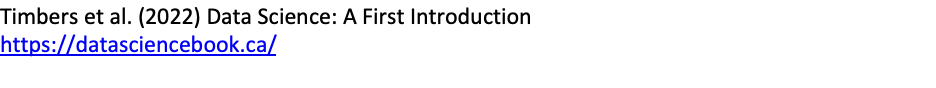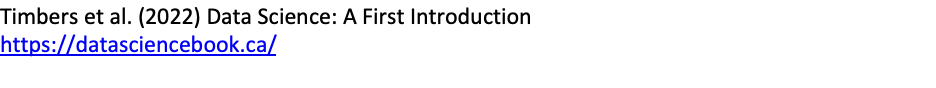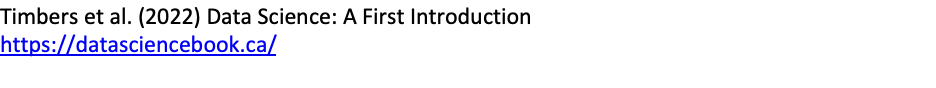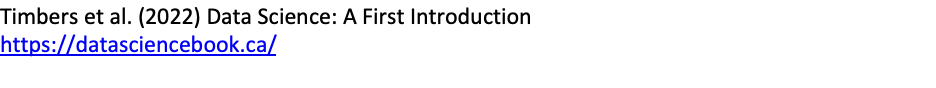

Zadora, G. (2007), Glass analysis for forensic purposes—a comparison of classification methods. J. Chemometrics, 21: 174-186. <br>
https://doi.org/10.1002/cem.1030